## Accessing and processing rock sample images from a Croissant file

This notebook demonstrates how standardized Croissant files can be used for Machine Learning-based data analysis. 
We use a Croissant file pointing to a set of low-resolution thin-section image pairs to access the data. The first step in the analysis consists of separating the rock sample in the image from the box around it. We then use clustering to perform a basic image segmentation process, which allows us to obtain a first visual approximation to the mineral composition of the sample based solely on pixel colors.

The Python environment required to run this notebook can be replicated using the api4ai_env.yml file included in the repository. The img_processing_functions and croissant_functions libraries (also present in the repository) are necessary as well, since they contain functions used to access or analyse the images.

In [2]:

import os
import mlcroissant as mlc
from skimage.io import imread, imshow

from croissant_functions import get_images_urls_api
from img_processing_functions import *

# Get image urls from croissant file:
f = 'https://resources.bgs.ac.uk/petrologyThinSectionsHighResDemo/api-croissant.json'
ds = mlc.Dataset(f)
record_set = ds.metadata.record_sets
ppl_urls, xpl_urls, sample_ids = get_images_urls_api (ds, record_set)

  -  [Metadata(bgs-api-thin-sections-api4ai)] Property "https://schema.org/datePublished" is recommended, but does not exist.


This notebook is written so that only one of the sample images is processed at a time, but the img_num parameter below allows running the analysis on any of the 99 pairs of images available for this example. 


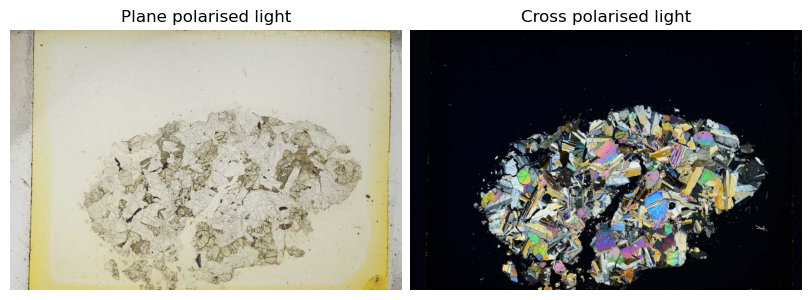

In [3]:
# Choose test image: cool examples are img_num 5, 10, 20, 30, 37, 40, 52, 61, 77
img_num = 77    # can take values from 0 to 98

# Get sample id, and fix it if necessary:
sample_id = sample_ids[img_num]
if '/' in sample_id: sample_id = sample_id.replace ('/', '')

# Load images:
ppl_img = imread (ppl_urls[img_num])
xpl_img = imread (xpl_urls[img_num])
xpl_img_gray = imread (xpl_urls[img_num], as_gray=True)

# Plot test image:
plot_test_image (ppl_img, xpl_img)

The first step in the processing is separating the rock sample in the image from the box containing it. The mask_from_xpl_image function, in the image_processing_functions library, takes the plane and cross polarised images and returns a mask, representing the rock sample area of the image,as well as masked versions of the input images.

In [4]:
# Get mask to separate sample from background/box:
ppl_masked, xpl_masked, mask = mask_from_xpl_image (xpl_img_gray, xpl_img, ppl_img, LR=True)
 

If we use pixel color as a proxy for mineral composition, image segmentation can provide information about the amount of different crystals in the rock sample, their size,
and how they are distributed. Here, we apply the kmeans_segmentation function to quickly and easily classify each pixel in the test images, with a fixed number of clusters.
There is no particular reason for choosing this value, other than visual inspection of the images and results showing it provides an adequate level of detail. 
There are more sophisticated ways of estimating the optimum number of clusters and performing image segmentation, but this is beyond the scope of this notebook.

In [5]:
# Use KMeans for some rough segmentation: 
# segmented_img is a "reconstruction" of the original image, assigning each 
# cluster the color closer to the original one. clust_img just assigns each
# pixel a cluster label. Clust_percs and clust_labels are the percentage
# of pixels in each cluster and a string label for each one.
segmented_img, clust_img, clust_percs, clust_labels = kmeans_segmentation (xpl_masked, num_clusters=7)


Percentage of pixels in each cluster (including box as Cluster 0):
Cluster 0 = 63.7 %
Cluster 1 = 9.4 %
Cluster 2 = 6.1 %
Cluster 3 = 6.9 %
Cluster 4 = 5.8 %
Cluster 5 = 6.1 %
Cluster 6 = 1.9 %


Let's have a look at the segmentation results! 

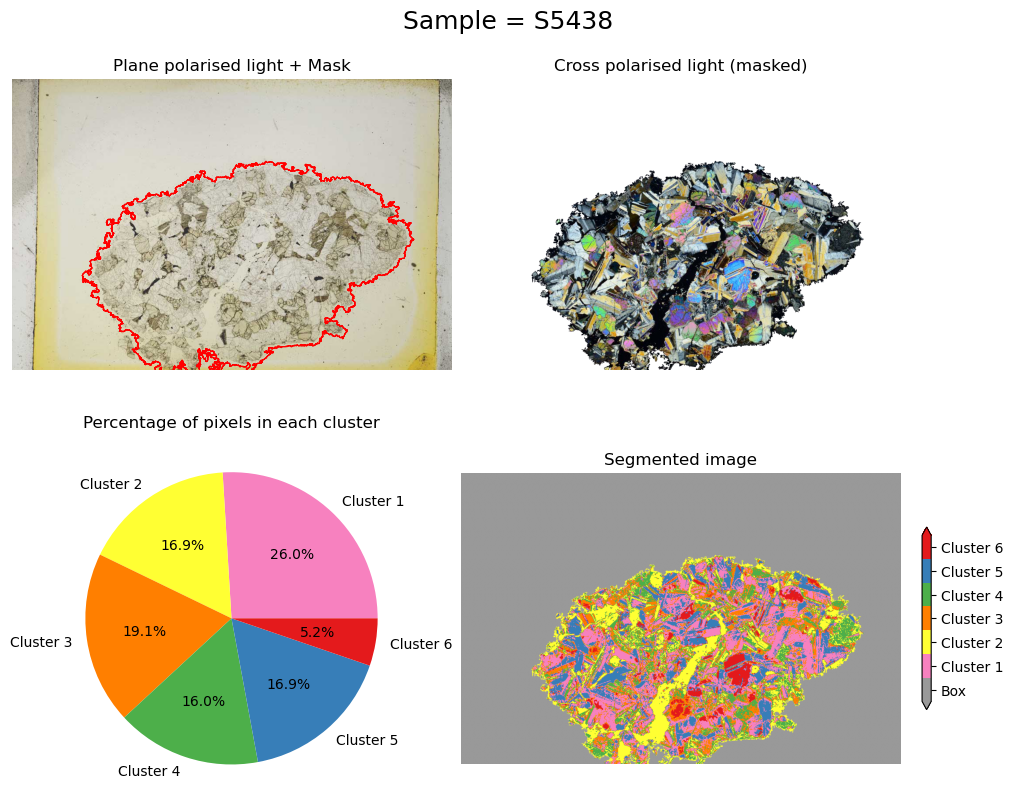

In [6]:
# Plot results:
plot_kmeans_segmentation_results (mask, xpl_masked, ppl_img, clust_img, clust_percs, clust_labels, sample_id)

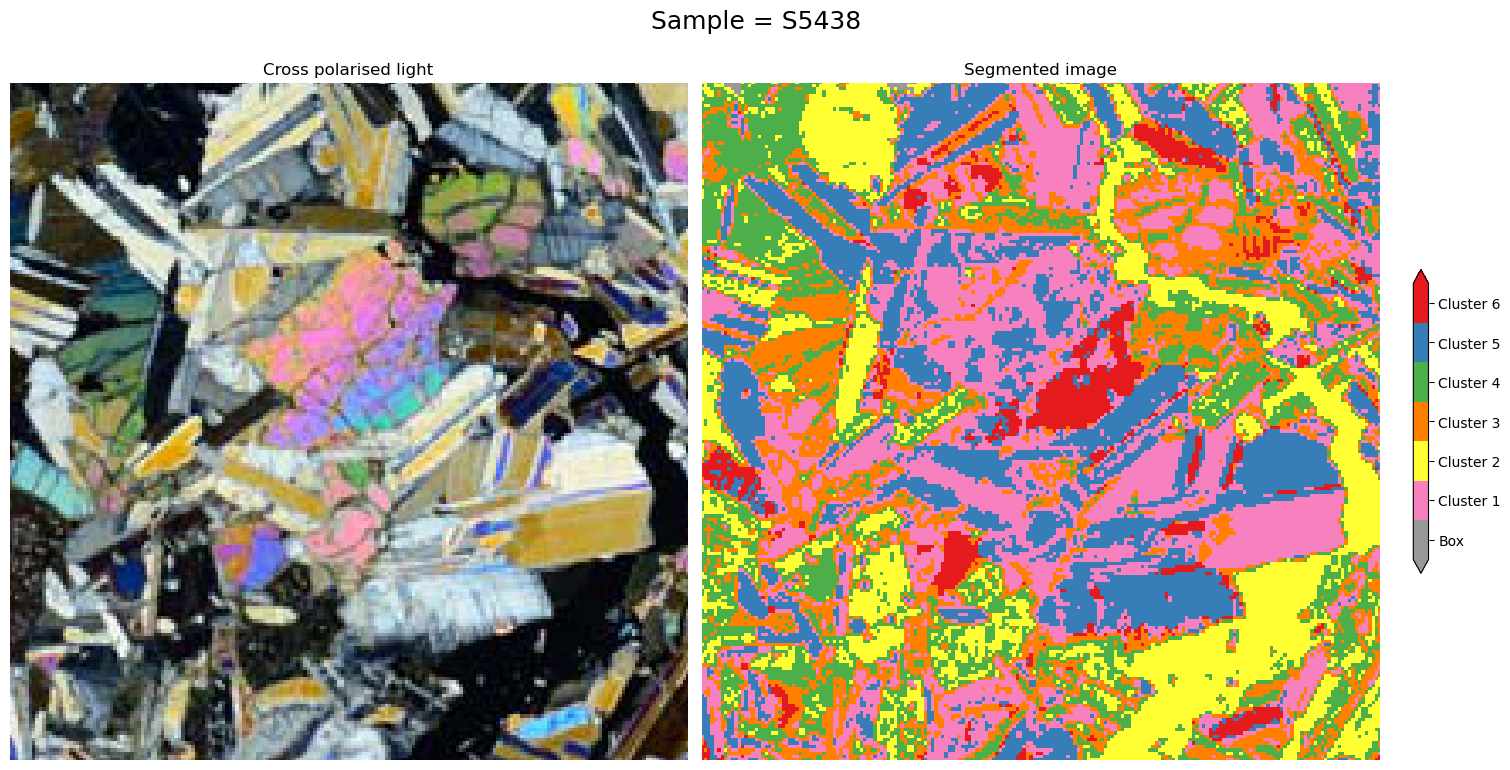

In [7]:
# Let's see them in more detail: the function below takes a 200x200 pixels square around the center of the image and plots the original xpl image next to the segmented version. 
plot_kmeans_segmentation_results_zoomed (xpl_img, clust_img, clust_labels, sample_id, LR=True)